# <p style="text-align:center;">Xây dựng mô hình dự đoán</p>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, mean_absolute_error, r2_score, mean_squared_error

In [12]:
df = pd.read_csv('../data/2425_QC_processed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  990 non-null    float64
 1   Age                       990 non-null    float64
 2   Area Income               990 non-null    float64
 3   Daily Internet Usage      990 non-null    float64
 4   Ad Topic Line             990 non-null    object 
 5   City                      990 non-null    object 
 6   Male                      990 non-null    int64  
 7   Country                   990 non-null    object 
 8   Timestamp                 990 non-null    object 
 9   Clicked on Ad             990 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 77.5+ KB


In [13]:
# Drop các cột categorical
df = df.select_dtypes(['number']) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  990 non-null    float64
 1   Age                       990 non-null    float64
 2   Area Income               990 non-null    float64
 3   Daily Internet Usage      990 non-null    float64
 4   Male                      990 non-null    int64  
 5   Clicked on Ad             990 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 46.5 KB


In [14]:
# Chia thành phần features và target
X = df.drop('Clicked on Ad', axis=1)
y = df['Clicked on Ad']

# Chia tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [15]:
# Chia thành 2 tập categorical và numerical để transform
categorical_fts = X.select_dtypes(include=["object"]).columns.tolist()

numerical_fts = X.select_dtypes(include=["number"]).columns.tolist()

In [16]:
# Mã hóa categorical feature và scale numerical feature
preprocessor = ColumnTransformer(
   transformers=[
       ("cat", OneHotEncoder(), categorical_fts),
       ("num", StandardScaler(), numerical_fts),
   ]
)

In [17]:
# Tạo dict chứa điểm đánh giá các model
metrics_score = {}

## <p style="text-align:center;">Decision Tree</p>

In [18]:
# Tạo pipeline
pipeline = Pipeline(
   [
       ("preprocessor", preprocessor),
       ("classifier", DecisionTreeClassifier(random_state= 42)),
   ]
)

In [19]:
# Parameters
param_grid = {
    'max_depth': [5, 10, 20]
}

# Fit model bằng tập train
best_dt_model = GridSearchCV(pipeline['classifier'], param_grid= param_grid, cv= 5)

best_dt_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = best_dt_model.predict(X_test)

# Tạo report
report = classification_report(y_test, y_pred, output_dict= True)

# Đánh giá bằng các regression metric
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

metrics_score['Decision Tree'] = {"MAE": mae, "R²": r2, "RMSE": rmse,
                                      "precision": precision, "recall": recall, "f1-score": f1}

print("Decision Tree:")
print(classification_report(y_test, y_pred))

Decision Tree:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        99
           1       0.96      0.94      0.95        99

    accuracy                           0.95       198
   macro avg       0.95      0.95      0.95       198
weighted avg       0.95      0.95      0.95       198



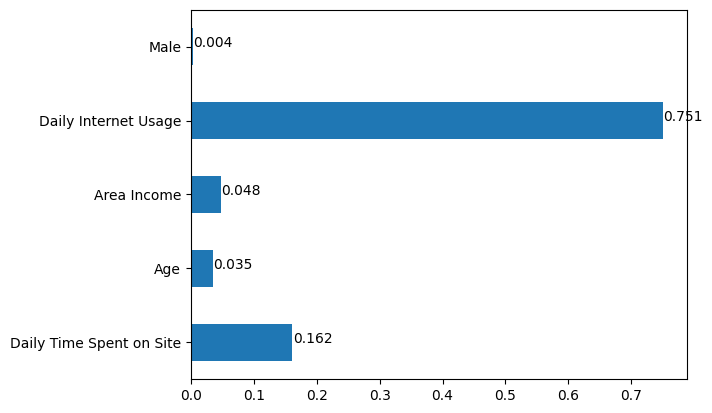

In [20]:
# Kiểm tra sự ảnh hưởng của các thuộc tính đối với mô hình
feat_importances = pd.Series(best_dt_model.best_estimator_.feature_importances_, index= X_train.columns)
feat_importances.plot(kind='barh')

for index, value in enumerate(feat_importances):
    value = round(value, 3)
    plt.text(value, index, str(value))
 
plt.show()

- Dựa trên biểu đồ, có thể thấy thuộc tính `Area Income` có ảnh hưởng không đáng kể đến mô hình `Decision Tree`.
- Đối với mô hình `Decision Tree`, chỉ có 2 thuộc tính `Daily Internet Usage` và `Daily Time Spent on Site` là có tương quan đáng kể đối với việc dự đoán khả năng   
click/không vào quảng cáo.

## <p style="text-align:center;">Random Forest</p>

In [21]:
# Tạo pipeline
pipeline = Pipeline(
   [
       ("preprocessor", preprocessor),
       ("classifier", RandomForestClassifier(random_state= 42)),
   ]
)

In [22]:
# Parameters
param_grid = {
    'n_estimators': [50, 200, 500],
    'max_depth': [5, 10, 20]
}

# Fit model bằng tập train
best_rf_model = GridSearchCV(pipeline['classifier'], param_grid= param_grid, cv= 5)

best_rf_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = best_rf_model.predict(X_test)

# Tạo report
report = classification_report(y_test, y_pred, output_dict= True)

# Đánh giá bằng các regression metric
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

metrics_score['Random Forest'] = {"MAE": mae, "R²": r2, "RMSE": rmse,
                                      "precision": precision, "recall": recall, "f1-score": f1}

print("Random Forest:")
print(classification_report(y_test, y_pred))

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        99
           1       0.97      0.97      0.97        99

    accuracy                           0.97       198
   macro avg       0.97      0.97      0.97       198
weighted avg       0.97      0.97      0.97       198



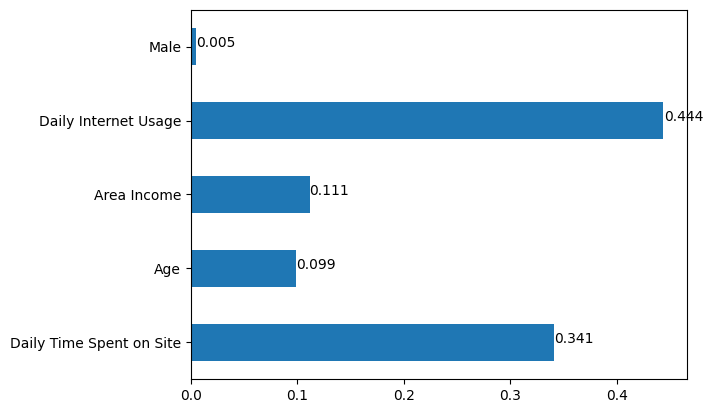

In [23]:
# Kiểm tra sự ảnh hưởng của các thuộc tính đối với mô hình
feat_importances = pd.Series(best_rf_model.best_estimator_.feature_importances_, index= X_train.columns)
feat_importances.plot(kind='barh')

for index, value in enumerate(feat_importances):
    value = round(value, 3)
    plt.text(value, index, str(value))
 
plt.show()

- Dựa trên biểu đồ, có thể thấy thuộc tính `Area Income` có ảnh hưởng đáng kể đến mô hình `Random Forest`.
- Đối với mô hình `Random Forest`, chỉ có duy nhất thuộc tính `Male` là không có sự tương quan đáng kể đối với việc dự đoán khả năng 
click/không vào quảng cáo.

## <p style="text-align:center;">Gradient Boosting</p>

In [24]:
# Tạo pipeline
pipeline = Pipeline(
   [
       ("preprocessor", preprocessor),
       ("classifier", GradientBoostingClassifier(random_state=42)),
   ]
)

In [25]:
# Parameters
param_grid = {
    'n_estimators': [50, 200, 500],
    'max_depth': [5, 10, 20]
}

# Fit model bằng tập train
best_gb_model = GridSearchCV(pipeline['classifier'], param_grid= param_grid, cv= 5)

best_gb_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = best_gb_model.predict(X_test)

# Tạo report
report = classification_report(y_test, y_pred, output_dict= True)

# Đánh giá bằng các regression metric
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

metrics_score['Gradient Boosting'] = {"MAE": mae, "R²": r2, "RMSE": rmse,
                                      "precision": precision, "recall": recall, "f1-score": f1}

print("Gradient Boosting:")
print(classification_report(y_test, y_pred))

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        99
           1       0.98      0.97      0.97        99

    accuracy                           0.97       198
   macro avg       0.97      0.97      0.97       198
weighted avg       0.97      0.97      0.97       198



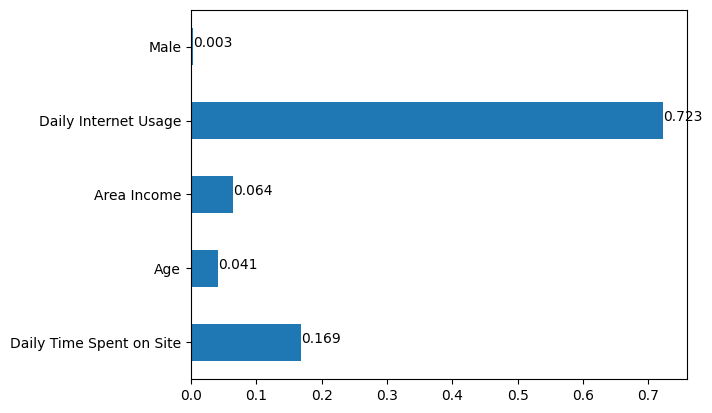

In [26]:
# Kiểm tra sự ảnh hưởng của các thuộc tính đối với mô hình
feat_importances = pd.Series(best_gb_model.best_estimator_.feature_importances_, index= X_train.columns)
feat_importances.plot(kind='barh')

for index, value in enumerate(feat_importances):
    value = round(value, 3)
    plt.text(value, index, str(value))
 
plt.show()

- Dựa trên biểu đồ, có thể thấy thuộc tính `Area Income` có ảnh hưởng không đáng kể đến mô hình `Gradient Boosting`.
- Đối với mô hình `Gradient Boosting`, có 2 thuộc tính `Daily Internet Usage` và `Daily Time Spent on Site` là có sự tương quan đáng kể đối với việc dự đoán khả năng   
click/không vào quảng cáo.

## <p style="text-align:center;">So sánh</p>

In [27]:
results_df = pd.DataFrame(metrics_score).T
display(results_df)

,MAE,R²,RMSE,precision,recall,f1-score
Decision Tree,0.050505,0.797980,0.224733,0.949678,0.949495,0.949490
Random Forest,0.030303,0.878788,0.174078,0.969697,0.969697,0.969697
Gradient Boosting,0.025253,0.898990,0.158910,0.974796,0.974747,0.974747


- Dựa trên các cột điểm đánh giá, có thể kết luận `Gradient Boosting` là mô hình có khả năng dự đoán tốt nhất trong 3 mô hình.